In [1]:
import os
os.chdir("../")
from data_management.DataManager import CALFData, collateGCN
import numpy as np
import torch 
from Model import ContextAwareModel
from helpers.loss import ContextAwareLoss, SpottingLoss
from modules.train import trainer
import pickle
from dataclasses import dataclass
import matplotlib.pyplot as plt
from modules.GameAnalysis import GamaAnalysis
import seaborn as sns
from helpers.classes import EVENT_DICTIONARY_V2_ALIVE as event_enc
from helpers.classes import get_K_params
import torch.nn as nn

In [2]:
@dataclass
class Args:
    # DATA
    datapath="../football_games"
    chunk_size = 60
    batch_size = 32
    input_channel = 13
    annotation_nr = 1
    receptive_field = 12
    fps = 5
    K_parameters = get_K_params(chunk_size)
    focused_annotation = None
    generate_augmented_data = True
    class_split = "alive"
    generate_artificial_targets = False
    
    # TRAINING
    chunks_per_epoch = 1824
    lambda_coord=5.0
    lambda_noobj=0.5
    patience=25
    LR=1e-03
    max_epochs=180
    max_num_worker=1
    loglevel='INFO'
    
    # SEGMENTATION MODULE
    feature_multiplier=1
    backbone_player = "GAT"
    load_weights=None
    model_name="Testing_Model"
    dim_capsule=16
    # VLAD pooling if applicable
    vocab_size=None
    pooling=None

    # SPOTTING MODULE
    sgementation_path = "models/backbone_GAT.pth.tar"
    freeze_model = None
    spotting_fps=1


In [9]:
args = Args
ann="Shot"
args.focused_annotation = ann
model_path = f"models/spotting_finetuned_{ann}.pth.tar"
model = torch.load(model_path)
game_analyser = GamaAnalysis(args, model)
game_analyser.all_test_games_evaluation(args, last_game_index=2, seg_model=False, calibrate=False, ann=ann, type_eval="map_evaluation")

Data preprocessing: 100%|██████████| 1/1 [00:09<00:00,  9.09s/it]


0.18592038983216375

In [6]:
game_analyser.map_results(ann)

0.16373261339653825

In [8]:
args = Args
ann="Shot"
args.focused_annotation = ann
model_path = f"models/finetuned_{ann}.pth.tar"
model = torch.load(model_path)
game_analyser = GamaAnalysis(args, model)
results, annotations = game_analyser.predict_game(0, seg_model=True, calibrate=False, ann=None)


Data preprocessing:   0%|          | 0/1 [00:00<?, ?it/s]

Data preprocessing: 100%|██████████| 1/1 [00:09<00:00,  9.60s/it]


0.01027449585022256

Data preprocessing: 100%|██████████| 1/1 [00:08<00:00,  8.66s/it]


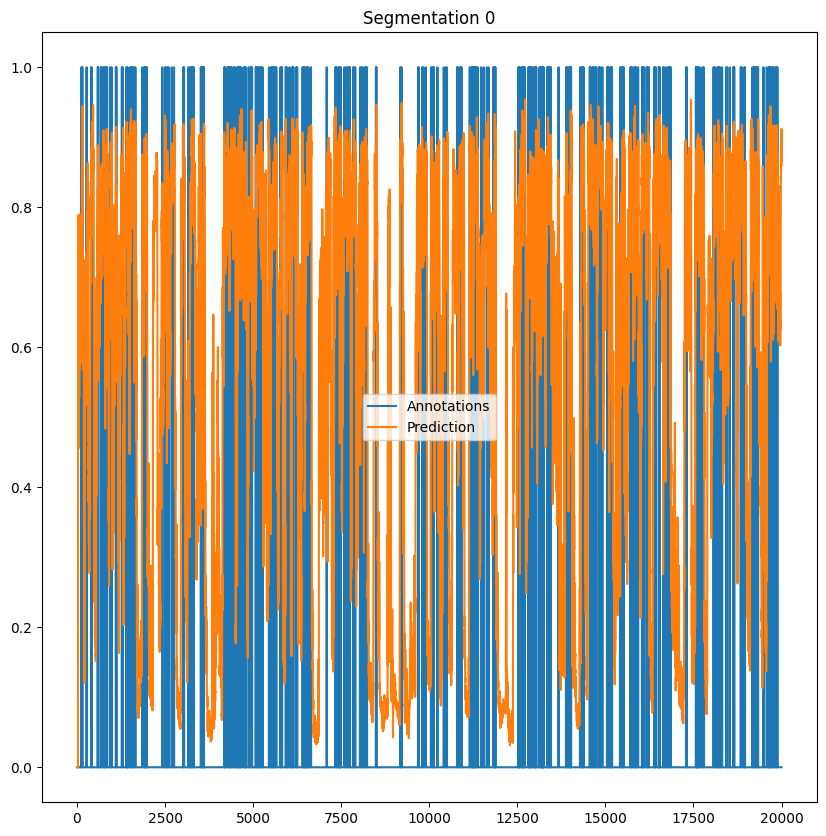

Data preprocessing: 100%|██████████| 1/1 [00:09<00:00,  9.03s/it]


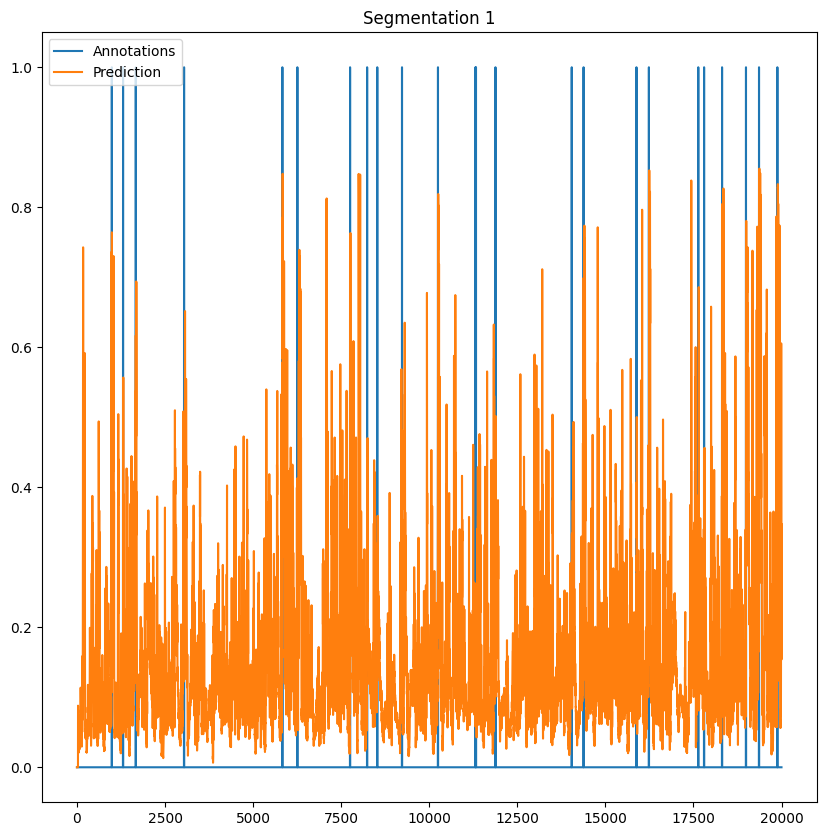

Data preprocessing: 100%|██████████| 1/1 [00:09<00:00,  9.58s/it]


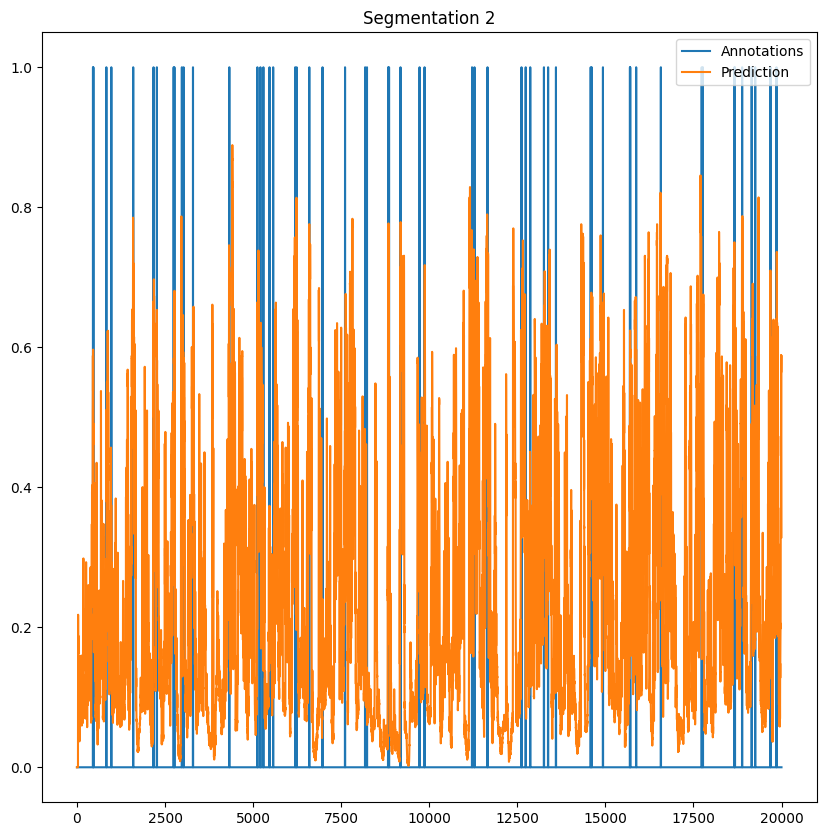

Data preprocessing: 100%|██████████| 1/1 [00:09<00:00,  9.79s/it]


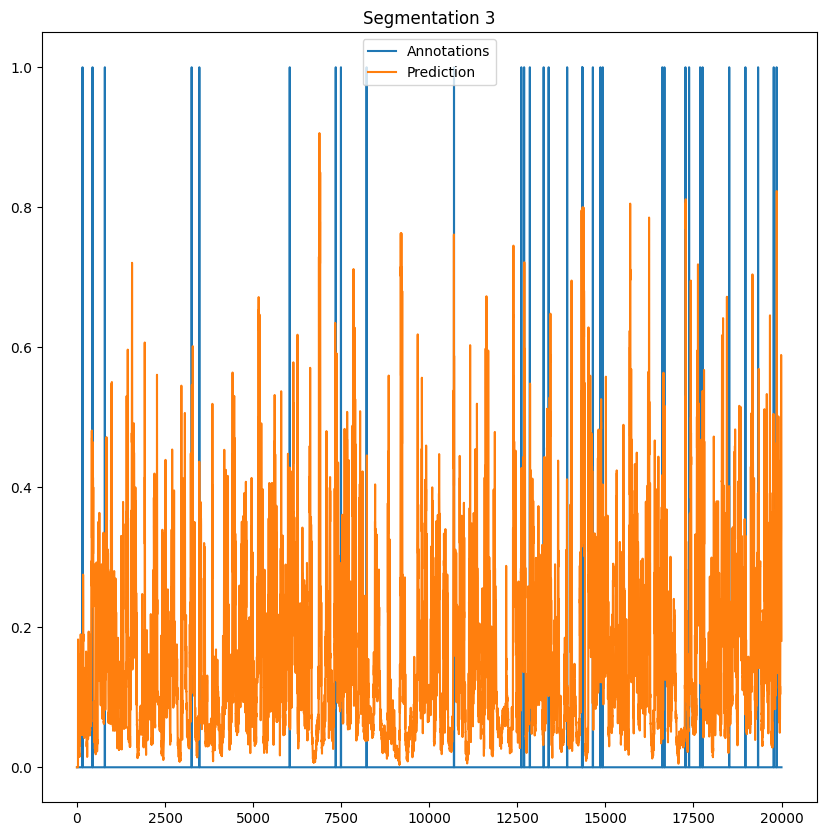

Data preprocessing: 100%|██████████| 1/1 [00:09<00:00,  9.00s/it]


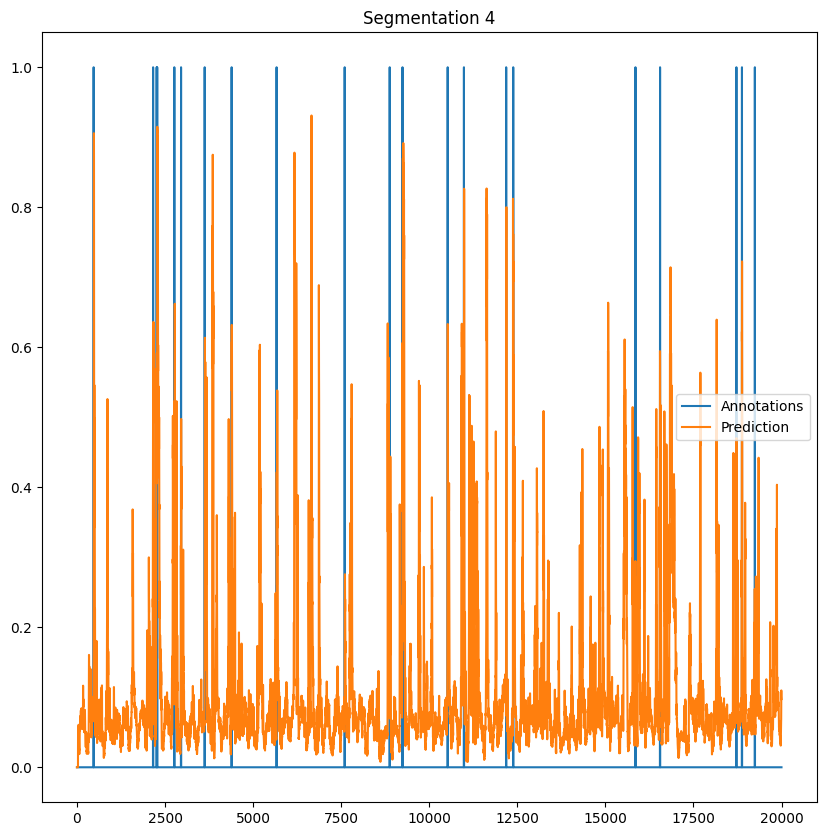

Data preprocessing: 100%|██████████| 1/1 [00:08<00:00,  8.85s/it]


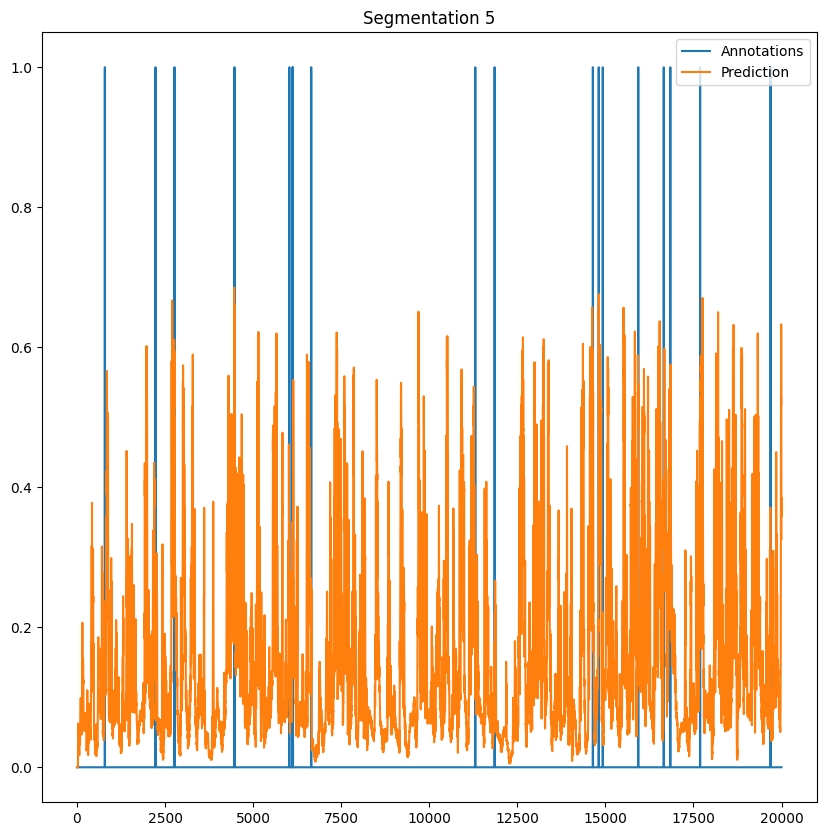

Data preprocessing: 100%|██████████| 1/1 [00:09<00:00,  9.07s/it]


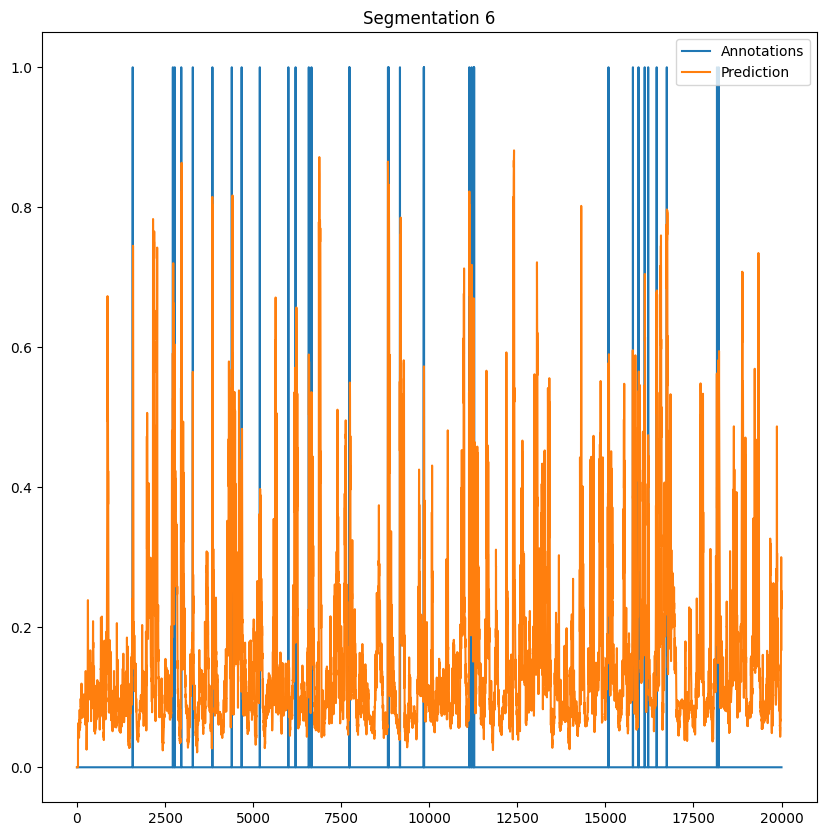

Data preprocessing: 100%|██████████| 1/1 [00:09<00:00,  9.02s/it]


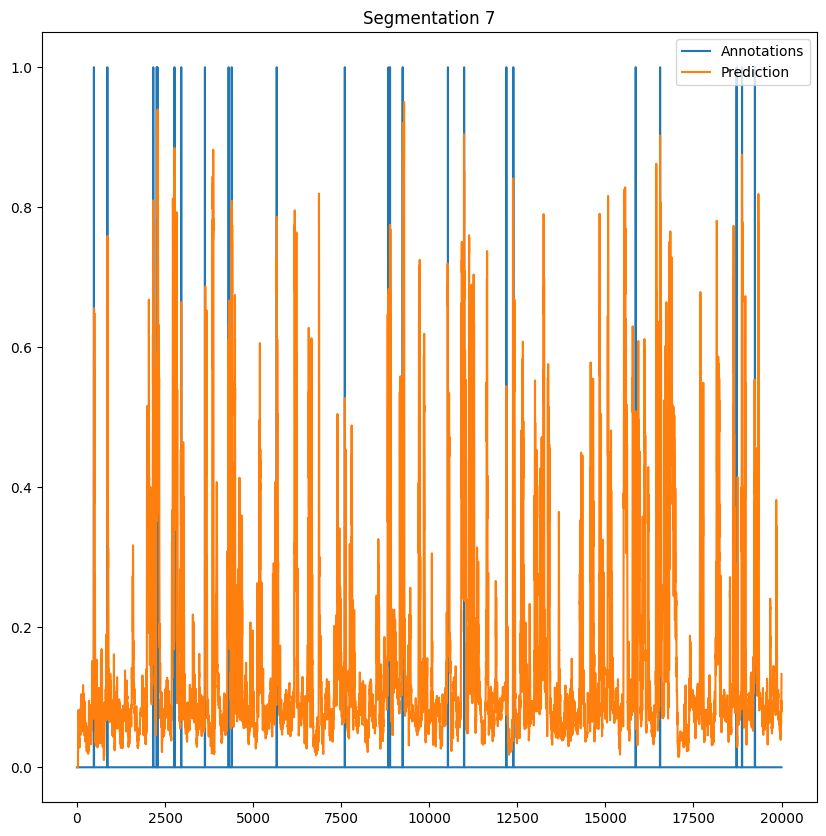

Data preprocessing: 100%|██████████| 1/1 [00:09<00:00,  9.37s/it]


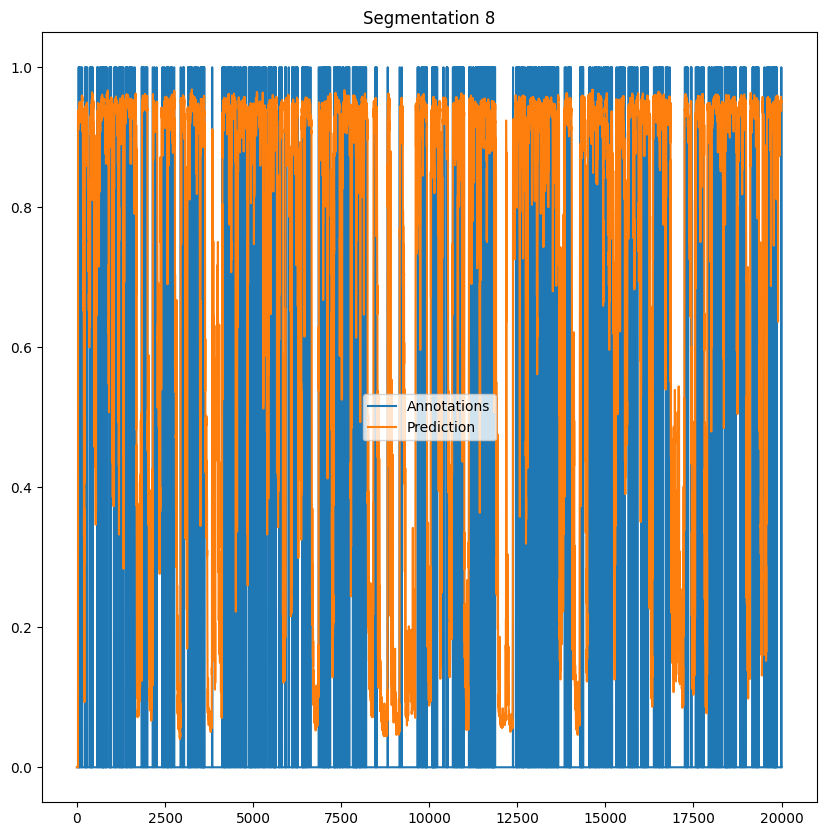

Data preprocessing: 100%|██████████| 1/1 [00:09<00:00,  9.24s/it]


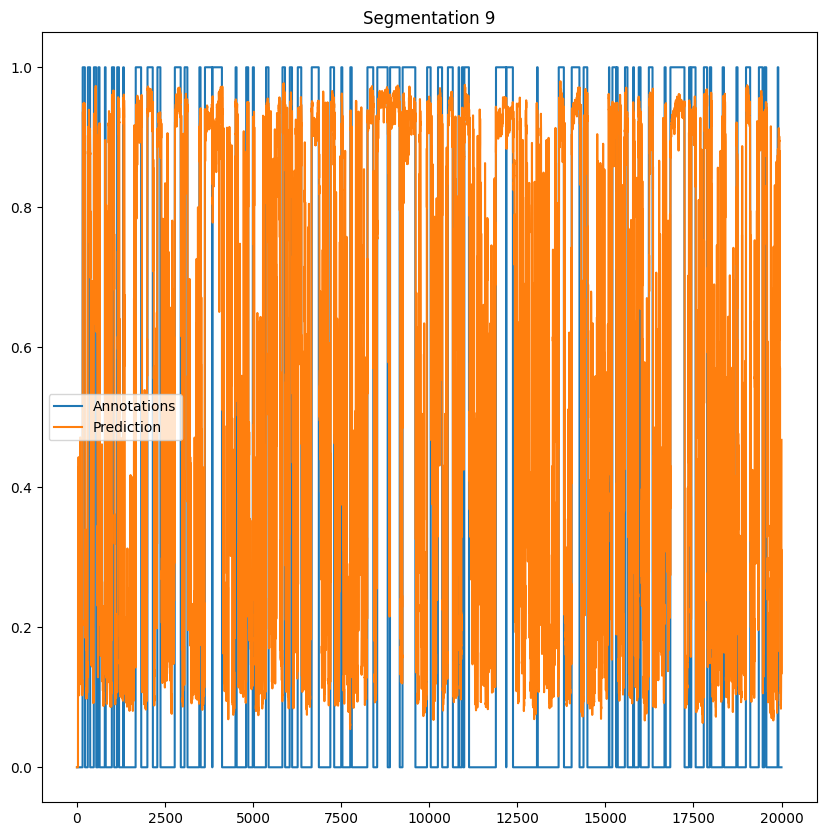

In [3]:
args = Args
# precisions_combined = np.empty(0)
# recalls_combined = np.empty(0)
# f1_combined = np.empty(0)
prediction_x_data = []
prediction_y_data = []

annotation_x_data = []
annotation_y_data = []

for i, ann in enumerate(event_enc.keys()):

    args.focused_annotation = ann

    model_path = f"models/finetuned_{ann}.pth.tar"
    model = torch.load(model_path)
    game_analyser = GamaAnalysis(args, model)
    results, annotations = game_analyser.predict_game(game_index=0, seg_model=True, calibrate=False, ann=ann)
    fig, ax = game_analyser.plot_predictions(frame_threshold=20000, save_dir=None, annotation=ann)
    
    prediction_x_data.append(ax.get_lines()[0].get_xdata()) 
    prediction_y_data.append(ax.get_lines()[0].get_ydata())

    annotation_x_data.append(ax.get_lines()[1].get_xdata()) 
    annotation_y_data.append(ax.get_lines()[1].get_ydata())

    # precision, recall, f1_score = game_analyser.segmentation_evaluation(ann)

    # precisions_combined = np.concatenate((precisions_combined, precision), axis=0)
    # recalls_combined = np.concatenate((recalls_combined, recall), axis=0)
    # f1_combined = np.concatenate((f1_combined, f1_score), axis=0)


# precisions_combined = np.concatenate((np.array([np.mean(precisions_combined)]), precisions_combined), axis=0)
# recalls_combined = np.concatenate((np.array([np.mean(recalls_combined)]), recalls_combined), axis=0)
# f1_combined = np.concatenate((np.array([np.mean(f1_combined)]), f1_combined), axis=0)


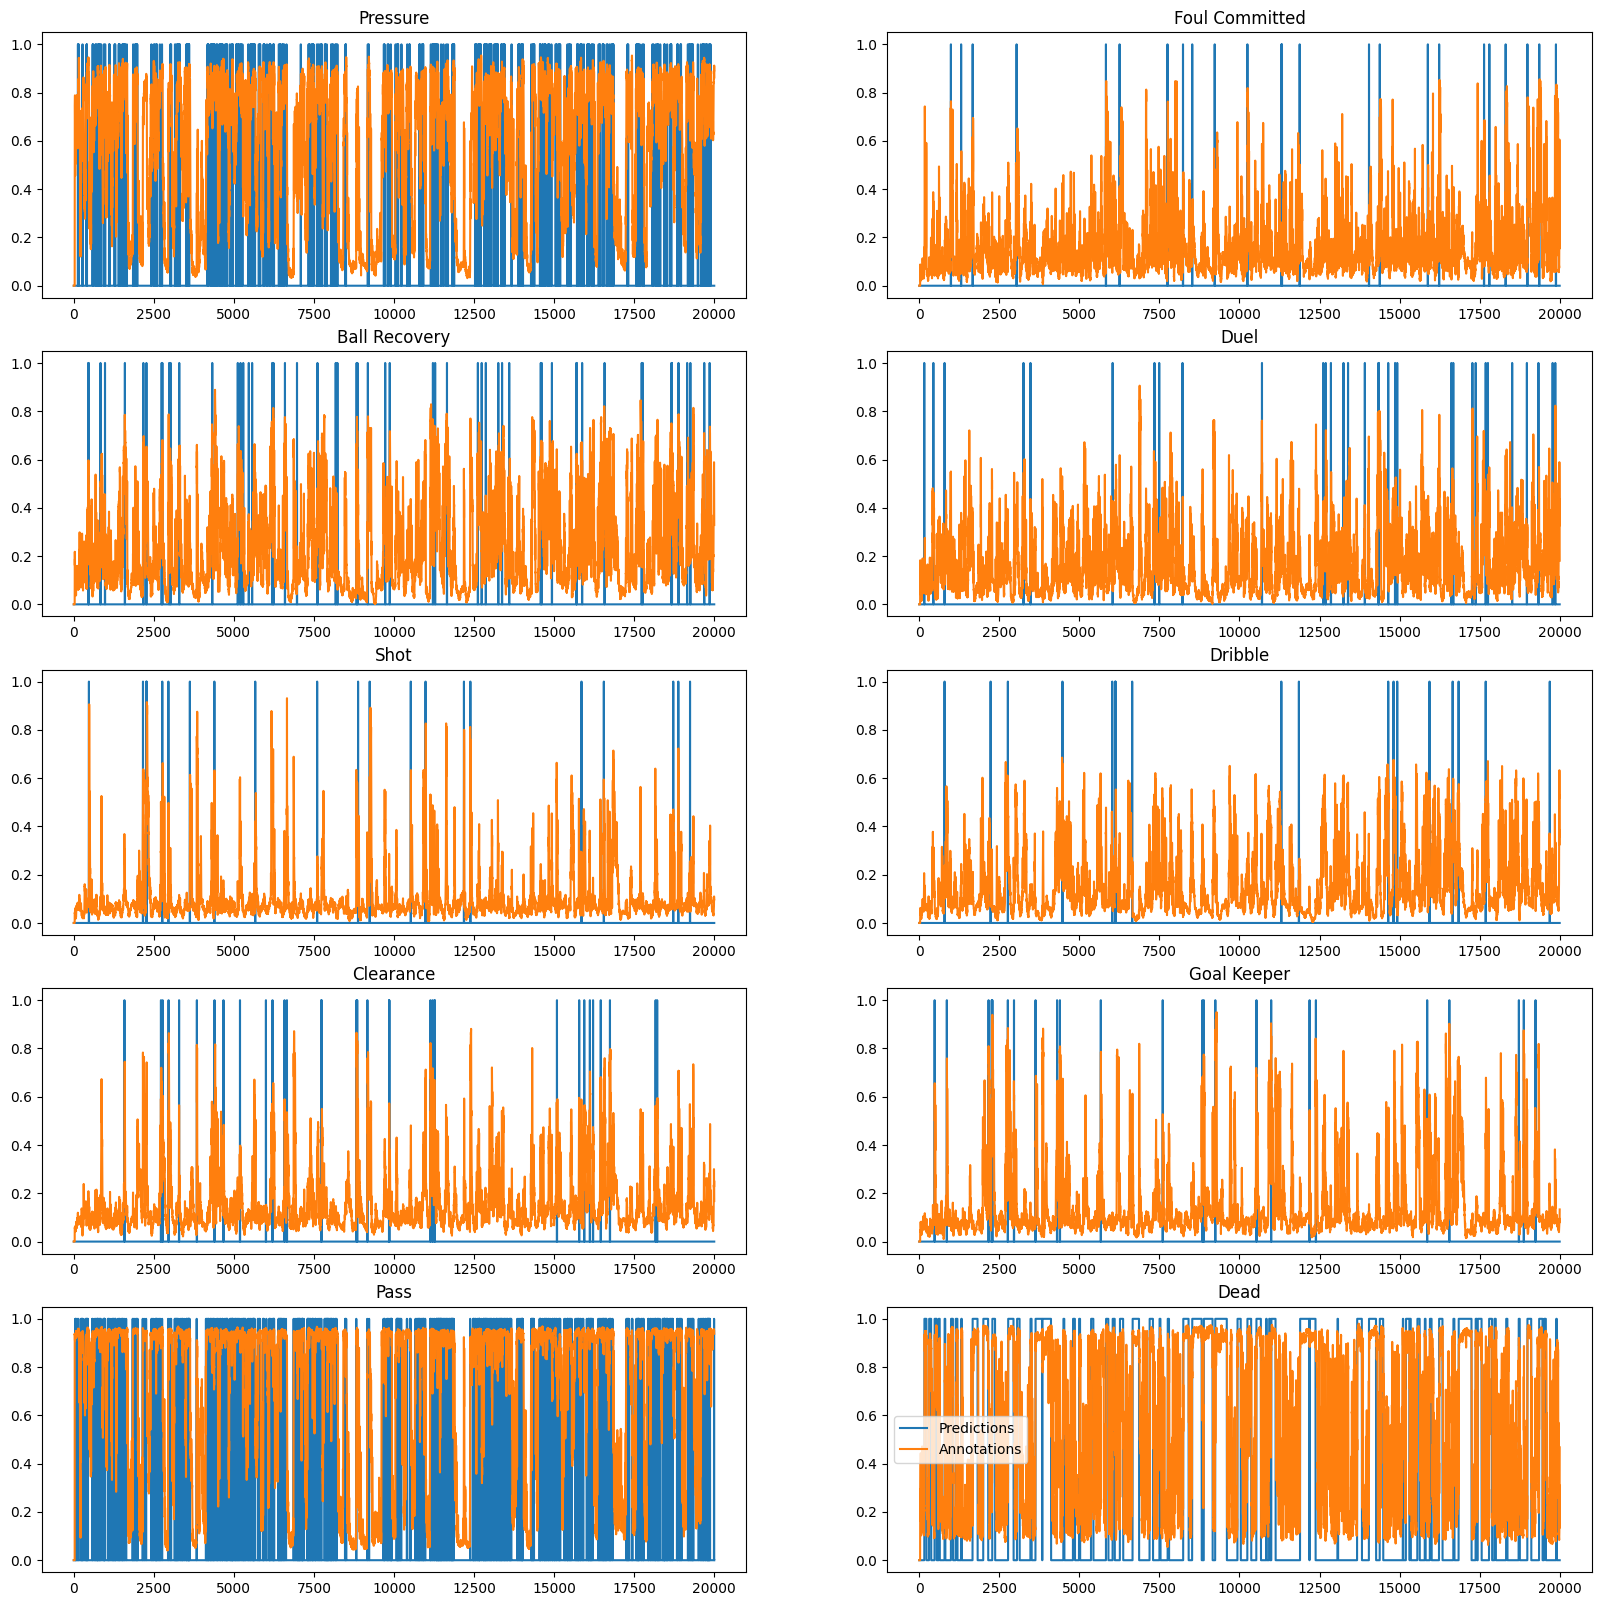

In [4]:
fig, axes = plt.subplots(5, 2, figsize=(20, 20))
axes_flattened = axes.flatten()

for i, ax in enumerate(axes_flattened):
    ax.plot(prediction_x_data[i], prediction_y_data[i], label="Predictions")
    ax.plot(annotation_x_data[i], annotation_y_data[i], label="Annotations")
    ax.set_title(list(event_enc)[i])

plt.legend()
plt.show()
    

In [5]:
args = Args
pors_combined = np.empty(0)
acrs_combined = np.empty(0)
f1_combined = np.empty(0)

for i, ann in enumerate(event_enc.keys()):

    args.focused_annotation = ann

    model_path = f"models/finetuned_{ann}.pth.tar"
    model = torch.load(model_path)
    game_analyser = GamaAnalysis(args, model)
    PORs, ACRs, f1_scores = game_analyser.all_test_games_evaluation(args, last_game_index=4, seg_model=True, calibrate=False, ann=ann, type_eval="segmentation_evaluation")

    pors_combined = np.concatenate((pors_combined, PORs), axis=0)
    acrs_combined = np.concatenate((acrs_combined, ACRs), axis=0)
    f1_combined = np.concatenate((f1_combined, f1_scores), axis=0)


pors_combined = np.concatenate((np.array([np.mean(pors_combined)]), pors_combined), axis=0)
acrs_combined = np.concatenate((np.array([np.mean(acrs_combined)]), acrs_combined), axis=0)
f1_combined = np.concatenate((np.array([np.mean(f1_combined)]), f1_combined), axis=0)


Data preprocessing: 100%|██████████| 1/1 [00:08<00:00,  8.38s/it]


In [12]:
f1_scores

array([0.75334715])

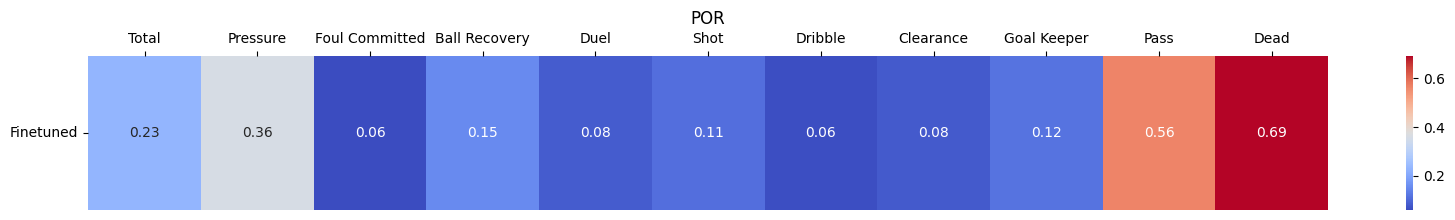

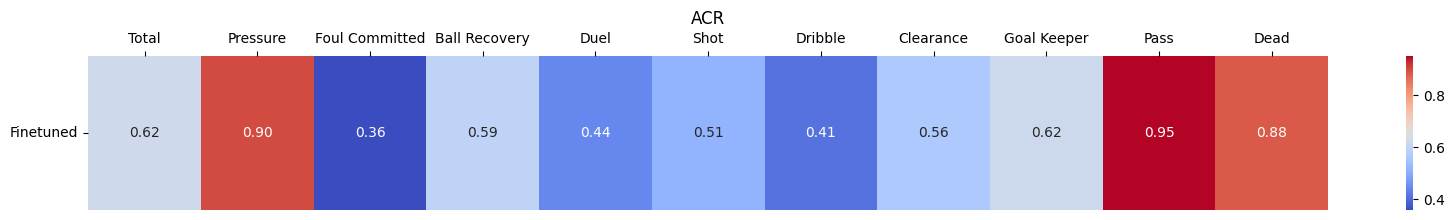

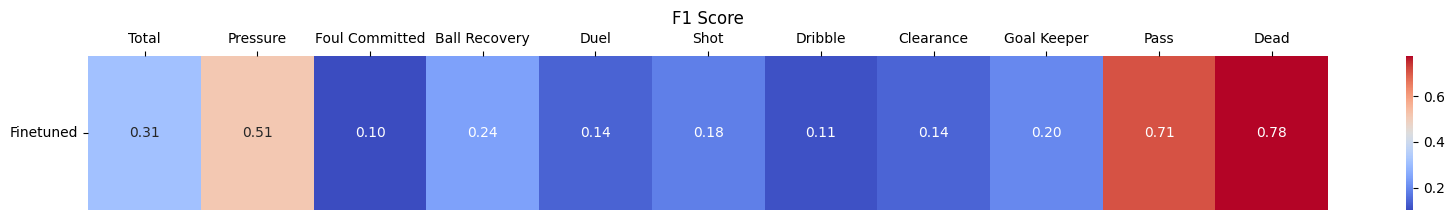

In [6]:
titles = ["POR", "ACR", "F1 Score"]
cols = ["Total"] + list(event_enc.keys())
rows = ["Finetuned"]
metrics = [pors_combined, acrs_combined, f1_combined]
for i, metric in enumerate(metrics):
    fig = plt.figure(figsize=(20, 2))
    ax = sns.heatmap(metric.reshape(1,-1), annot=True, cmap="coolwarm", fmt=".2f", xticklabels=True, yticklabels=True)
    ax.set_xticklabels(cols, rotation=0)
    ax.xaxis.tick_top()
    ax.set_yticklabels(rows, rotation=0)

    plt.title(titles[i])
    plt.show()

In [7]:
pors_combined

array([0.22828177, 0.35993282, 0.05940426, 0.15309387, 0.0822919 ,
       0.11017703, 0.06431509, 0.08002182, 0.11763028, 0.56454805,
       0.69140261])

In [8]:
f1_combined

array([0.31128038, 0.51394048, 0.10196518, 0.24340439, 0.13868078,
       0.18148641, 0.11123743, 0.14009674, 0.19774574, 0.70847127,
       0.77577537])

In [9]:
acrs_combined

array([0.62343869, 0.89830716, 0.35961785, 0.59352869, 0.44057815,
       0.51445422, 0.41133512, 0.56203217, 0.6200454 , 0.95088555,
       0.88360255])

In [10]:
map_combined = []
args = Args

for i, ann in enumerate(event_enc.keys()):    
    args.focused_annotation = ann
    model_path = f"models/spotting_finetuned_{ann}.pth.tar"
    model = torch.load(model_path)
    game_analyser = GamaAnalysis(args, model)
    map_score = game_analyser.all_test_games_evaluation(args, last_game_index=4, seg_model=False, calibrate=False, ann=ann, type_eval="map_evaluation")
    map_combined.append(map_score)

Data preprocessing: 100%|██████████| 1/1 [00:08<00:00,  8.51s/it]


In [11]:
map_combined

[0.24059528691054832,
 0.11623747967577246,
 0.0942354961065224,
 0.05319775428032598,
 0.2470391088651238,
 0.04408738625774243,
 0.20002759782113264,
 0.19564671972256895,
 0.37179957676253317,
 0.9182990393887266]

In [6]:
precision = []
recall = []
f1_scores = []
args = Args

for i, ann in enumerate(event_enc.keys()):    
    args.focused_annotation = ann
    model_path = f"models/spotting_finetuned_{ann}.pth.tar"
    model = torch.load(model_path)
    game_analyser = GamaAnalysis(args, model)
    p,r,f1 = game_analyser.all_test_games_evaluation(args, last_game_index=4, seg_model=False, calibrate=True, ann=ann, type_eval="clip_based_precision_recall")
    precision.append(p)
    recall.append(r)
    f1_scores.append(f1)

Data preprocessing: 100%|██████████| 1/1 [00:08<00:00,  8.30s/it]


In [7]:
precision

[array([0.41698113]),
 array([0.12602291]),
 array([0.1726094]),
 array([0.1047486]),
 array([0.27402135]),
 array([0.06889353]),
 array([0.18362832]),
 array([0.22115385]),
 array([0.6495795]),
 array([0.54605263])]

In [9]:
recall

[array([0.71232877]),
 array([0.6637931]),
 array([0.69155844]),
 array([0.52083333]),
 array([0.63636364]),
 array([0.62264151]),
 array([0.75454545]),
 array([0.83333333]),
 array([0.6609617]),
 array([0.90958904])]

In [11]:
f1_scores

[array([0.52603392]),
 array([0.21182944]),
 array([0.27626459]),
 array([0.1744186]),
 array([0.38308458]),
 array([0.12406015]),
 array([0.29537367]),
 array([0.34954407]),
 array([0.65522117]),
 array([0.68242549])]

In [12]:
np.mean(f1_scores)

0.3678255672146938

In [5]:
ann = "Shot"
args = Args
args.focused_annotation = ann
model_path = f"models/spotting_finetuned_{ann}.pth.tar"
model = torch.load(model_path)
game_analyser = GamaAnalysis(args, model)
game_analyser.all_test_games_evaluation(args, last_game_index=1, seg_model=False, calibrate=True, ann=ann, type_eval="clip_based_precision_recall")

Data preprocessing: 100%|██████████| 1/1 [00:09<00:00,  9.60s/it]


(array([0.28813559]), array([0.56666667]), array([0.38202247]))

In [12]:
np.mean(map_combined)

0.24811654457909968

In [2]:
@dataclass
class Args:
    # DATA
    datapath="../football_games"
    chunk_size = 60
    batch_size = 32
    input_channel = 13
    annotation_nr = 10
    receptive_field = 12
    fps = 5
    K_parameters = get_K_params(chunk_size)
    focused_annotation = None
    generate_augmented_data = True
    class_split = "alive"
    generate_artificial_targets = False
    
    # TRAINING
    chunks_per_epoch = 1824
    lambda_coord=5.0
    lambda_noobj=0.5
    patience=25
    LR=1e-03
    max_epochs=180
    max_num_worker=1
    loglevel='INFO'
    
    # SEGMENTATION MODULE
    feature_multiplier=1
    backbone_player = "GAT"
    load_weights=None
    model_name="Testing_Model"
    dim_capsule=16
    # VLAD pooling if applicable
    vocab_size=None
    pooling=None

    # SPOTTING MODULE
    sgementation_path = [f"models/finetuned_{ann}.pth.tar" for ann in event_enc.keys()]
    freeze_model = None
    spotting_fps=1


In [3]:
for i, ann in enumerate(event_enc.keys()):
    args = Args
    ann="Pass"
    args.focused_annotation = ann
    model_path = f"models/spotting_finetuned_{ann}.pth.tar"
    model = torch.load(model_path)
    game_analyser = GamaAnalysis(args, model)
    results, annotations = game_analyser.predict_game(0, seg_model=False, calibrate=False, ann=ann)

In [4]:
collate_fn = collateGCN
train_dataset = CALFData(split="train", args=args)
train_loader = torch.utils.data.DataLoader(train_dataset,
            batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

Get labels & features: 100%|██████████| 4/4 [00:30<00:00,  7.58s/it]


In [5]:
_,_,rep = next(iter(train_loader))

res = model(rep)

: 

In [ ]:
@dataclass
class Args:
    # DATA
    datapath="/project_antwerp/football_games"
    chunk_size = 60
    batch_size = 32
    input_channel = 13
    annotation_nr = 1
    receptive_field = 12
    fps = 5
    K_parameters = get_K_params(chunk_size)
    focused_annotation = None
    generate_augmented_data = True
    class_split = "alive"
    generate_artificial_targets = False
    
    # TRAINING
    chunks_per_epoch = 1824
    lambda_coord=5.0
    lambda_noobj=0.5
    patience=25
    LR=1e-03
    max_epochs=180
    max_num_worker=1
    loglevel='INFO'
    
    # SEGMENTATION MODULE
    feature_multiplier=1
    backbone_player = "GAT"
    load_weights=None
    model_name="Testing_Model"
    dim_capsule=16
    # VLAD pooling if applicable
    vocab_size=None
    pooling=None

    # SPOTTING MODULE
    sgementation_path = "/project_antwerp/models/backbone_GAT.pth.tar"
    freeze_model = None
    spotting_fps=1


In [11]:
@dataclass
class Args:
    # DATA
    datapath="../football_games"
    chunk_size = 60
    batch_size = 32
    input_channel = 13
    annotation_nr = 1
    receptive_field = 12
    fps = 5
    K_parameters = get_K_params(chunk_size)
    focused_annotation = "Shot"
    generate_augmented_data = True
    class_split = "alive"
    generate_artificial_targets = False
    
    # TRAINING
    chunks_per_epoch = 1824
    lambda_coord=5.0
    lambda_noobj=0.5
    patience=25
    LR=1e-03
    max_epochs=180
    max_num_worker=1
    loglevel='INFO'
    
    # SEGMENTATION MODULE
    feature_multiplier=1
    backbone_player = "GAT"
    load_weights=None
    model_name="Testing_Model"
    dim_capsule=16
    # VLAD pooling if applicable
    vocab_size=None
    pooling=None

    # SPOTTING MODULE
    sgementation_path = f"models/finetuned_Shot.pth.tar"
    freeze_model = None
    spotting_fps=1


In [13]:
from Model import SpottingModel
args = Args()
model = SpottingModel(args)

In [14]:
collate_fn = collateGCN
train_dataset = CALFData(split="train", args=args)
train_loader = torch.utils.data.DataLoader(train_dataset,
            batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

Data preprocessing:   0%|          | 0/1 [00:00<?, ?it/s]

Get labels & features: 100%|██████████| 4/4 [00:25<00:00,  6.49s/it]


In [15]:
_,_,rep = next(iter(train_loader))

res = model(rep)

In [16]:
res.shape

torch.Size([32, 48, 1])

In [19]:
labels,targets,rep = next(iter(train_loader))